In [31]:
#knr, mlp, br, brr, gpr, svr, sgd, rfr, adar
from sklearn.model_selection import train_test_split as TTS, cross_validate as cv 
from sklearn.preprocessing import MinMaxScaler as MMS, StandardScaler as SScaler
from sklearn.ensemble import RandomForestRegressor as RFR, AdaBoostRegressor as ADA
from sklearn.linear_model import SGDRegressor as SGD, BayesianRidge as BRR
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error as MSE, r2_score as r2
from sklearn.model_selection import GridSearchCV as GSCV
from matplotlib import pyplot as plt
import time, scipy, numpy as np, math, pickle, random, warnings, pandas as pd, csv, hyperas
from sklearn.pipeline import Pipeline
from hyperopt import STATUS_OK, tpe, Trials, hp, fmin
from functools import partial
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from joblib import dump, load
import os

In [54]:
FILE_NAME = "Nov27_All.csv"
SCALE_NAME = "Planar_Scale_"
NUM_EX = 3

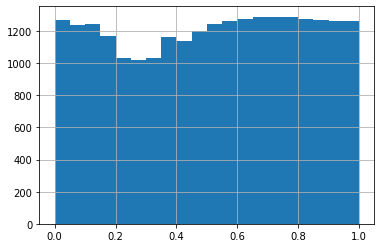

In [55]:
def get_data(label, name=FILE_NAME): #YOGI16 before
    frame = pd.read_csv(name)
    frame = frame[frame['E'] != 0] #remove missing rows
    #frame = frame[frame['CERd'] > -30]
    
    if (label == 'i_total'):
        #frame['i'] = (frame['CER'] + frame['HER'])/(f['P']*f['P']*10**-6*10**-6)
        frame['i'] = (frame['CER'] + frame['HER'])/(20*20*10**-6*10**-6)
        frame['i_total'] = frame.apply(lambda x: math.log10(-1*x.i), axis=1) #calc cur density
        frame.drop(['CER','HER','i'], axis=1, inplace=True)
        ax = frame['i_total'].hist(bins=20)
        ax.set_xlabel('Current (A/m^2)')
        ax.set_ylabel('Count')
        ax.set_title('Current Density Distribution (Yogi Model)')
        #plt.savefig('Yogi_Current_Density_Dist.png')
        plt.show()
    else:
        frame['FE'] = round(frame['CER']/(frame['CER']+frame['HER']), 5)
        frame.drop(['CER','HER'], axis=1, inplace=True)
        ax = frame['FE'].hist(bins=20)
        plt.show()
    for i in range(NUM_EX): #take logs of exchange current densities
        frame.iloc[:,2+i] = frame.iloc[:,2+i].apply(lambda x: math.log10(x))
    x_t, X_T, y_t, Y_T = TTS(frame.iloc[:,:-1], (frame[label]), test_size=0.2, random_state=26)
    return x_t, y_t, X_T, Y_T, frame
x_t, y_t, X_T, Y_T, frame = get_data('FE')

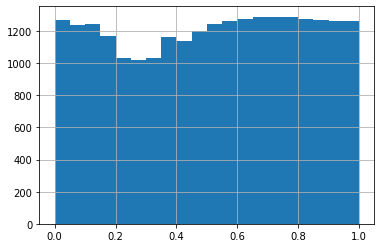

New Scaler Planar_Scale_0.bin


,E,ord,Ex1,Ex2,Ex3,dif,FE
0,-0.58,0.316691,-4.570000,-3.300000,3.880000,434.1,0.00231
1,-0.64,0.884189,-5.510000,-5.560000,1.350000,384.1,0.00204
2,-0.56,0.738607,-5.510000,-3.320000,-5.960000,185.1,0.00075
3,-0.41,0.398945,-5.970000,-8.300000,1.100000,412.1,0.00001
4,-0.43,0.131133,-4.040000,-1.930000,1.370000,220.1,0.00064
...,...,...,...,...,...,...,...
24193,-0.53,0.796278,-3.470000,-7.679999,-2.710000,395.1,0.99777
24194,-0.69,0.776656,-0.920000,-8.710001,-3.920002,307.1,0.99997
24195,-0.90,0.573321,-3.979999,-9.420000,-4.440000,326.1,0.99944
24196,-0.45,0.391542,0.430000,-8.150000,-2.940000,331.1,0.99995


In [56]:
def init_data_tf(label, path, size=0, name=FILE_NAME):
    x_t, y_t, X_T, Y_T, frame = get_data(label, name)
    x_t_info = x_t.describe()
    x_t_info = x_t_info.transpose()
    scale_path = path + SCALE_NAME + str(size) + '.bin'
    if (os.path.exists(scale_path)):
        print(f'Found {scale_path}')
        scale = load(scale_path)
    else:
        scale = SScaler()
        print(f'New Scaler {scale_path}')
    x_t = scale.fit_transform(x_t)
    X_T = scale.transform(X_T)
    dump(scale, scale_path, compress=True)
    return x_t, y_t, X_T, Y_T, frame
x_t, y_t, X_T, Y_T, frame = init_data_tf('FE', "")
frame

In [57]:
#imports we know we'll need
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from keras.models import Sequential
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.python.framework import ops

In [58]:
dim_learning_rate = Real(low=1e-9, high=0.1, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=2, high=15, name='num_dense_layers')
dim_num_input_nodes = Integer(low=7, high=2500, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=50, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu'], name='activation')
dim_batch_size = Integer(low=1, high=100, name='batch_size')
dim_adam_decay = Real(low=1e-50,high=0.1,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay]
default_parameters = [1e-3, 2, 7, 13, 'relu', 64, 1e-3]

In [59]:
def create_model(learning_rate, num_dense_layers, num_input_nodes,
                 num_dense_nodes, activation, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape=(6,), activation=activation))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
    #output layer, 1 node for regression
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss=['mse'], metrics=['mse'])
    return model

In [60]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, 
            num_dense_nodes, activation, batch_size, adam_decay):

    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay)
    #named blackbox becuase it represents the structure
    blackbox = model.fit(x=x_t,
                        y=y_t,
                        epochs=6,
                        batch_size=batch_size,
                        validation_split=0.15,
                        verbose=False) #i picked 20 epochs off of a generic MLP i trained
    #return the validation accuracy for the last epoch.
    error = blackbox.history['val_mse'][-1]
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    # Clear the Keras session, otherwise it will keep adding new models to the same graph 
    K.clear_session()
    #tf.reset_default_graph() -- didn't work, ops follows Stack Overflow suggestion
    ops.reset_default_graph()
    return error

./Planar/DataSets/Data_1200.csv


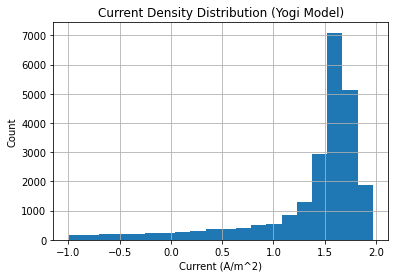

New Scaler ./Planar/1200_Results/Planar_Scale_1200.bin
Training Size 18678
Testing Size 4670


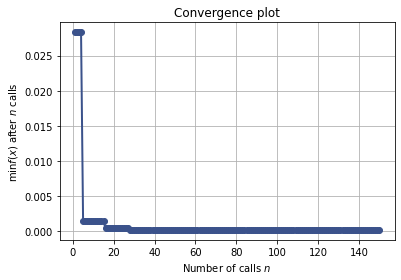

{'Learning_Rate': 0.007291666107152635, 'Dense_Layers': 15, 'Input_Nodes': 2500, 'Dense_Nodes': 39, 'Activation': 'relu', 'Batch_Size': 100, 'Adam_Decay': 1e-50}
{'Learning_Rate': 0.007291666107152635, 'Dense_Layers': 15, 'Input_Nodes': 2500, 'Dense_Nodes': 39, 'Activation': 'relu', 'Batch_Size': 100, 'Adam_Decay': 1e-50}


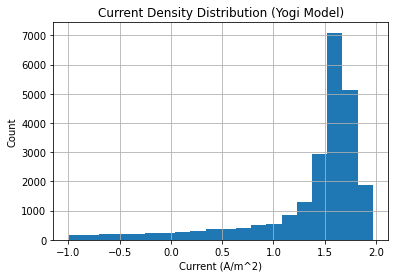

Found ./Planar/1200_Results/Planar_Scale_1200.bin
INFO:tensorflow:Assets written to: ./Planar/1200_Results/i_total_Model/assets


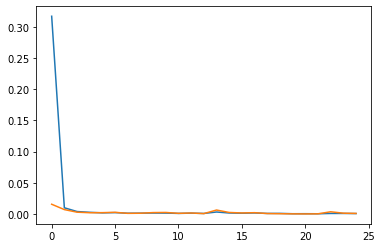

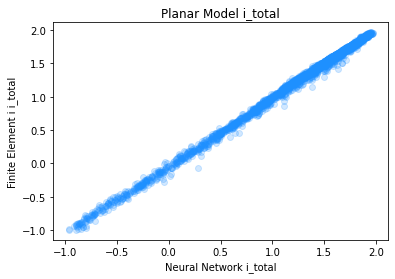

Test set error: 0.001022248363310209
Training Error: 0.0009302743353613009


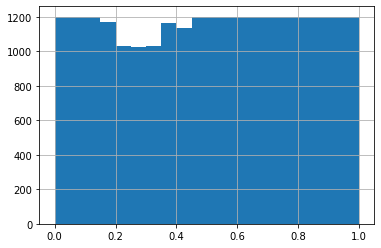

Found ./Planar/1200_Results/Planar_Scale_1200.bin
Training Size 18678
Testing Size 4670


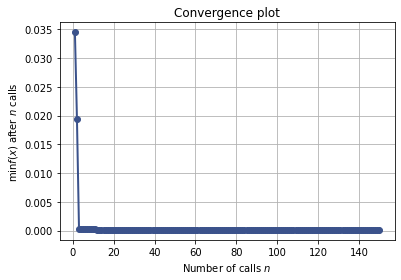

{'Learning_Rate': 0.0038757877233915818, 'Dense_Layers': 15, 'Input_Nodes': 2500, 'Dense_Nodes': 11, 'Activation': 'relu', 'Batch_Size': 1, 'Adam_Decay': 0.0024813334399314563}
{'Learning_Rate': 0.0038757877233915818, 'Dense_Layers': 15, 'Input_Nodes': 2500, 'Dense_Nodes': 11, 'Activation': 'relu', 'Batch_Size': 1, 'Adam_Decay': 0.0024813334399314563}


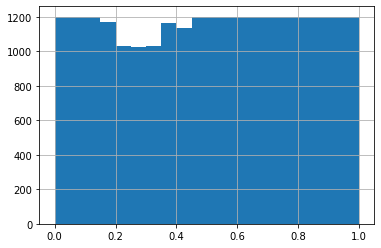

Found ./Planar/1200_Results/Planar_Scale_1200.bin
INFO:tensorflow:Assets written to: ./Planar/1200_Results/FE_Model/assets


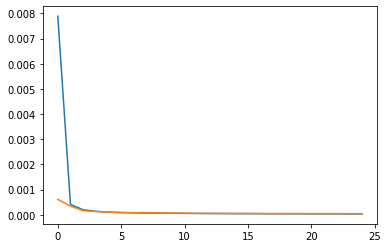

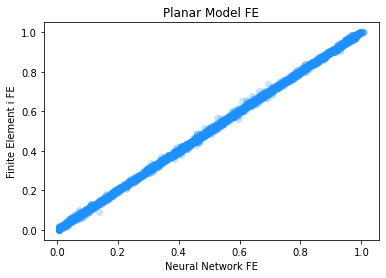

Test set error: 4.082249806364211e-05
Training Error: 3.168600784564159e-05


<Figure size 432x288 with 0 Axes>

In [61]:
%matplotlib inline
from skopt.plots import plot_convergence #skopt used for TF neural nets
import glob
import pickle

def conv_data(conv_results, file):
    x = range(len(conv_results))
    min_val = conv_results[0]
    ans = []
    for res in conv_results:
        if (res < min_val): min_val = res
        if res > min_val: res = min_val
        ans.append(res)
    df = pd.DataFrame(ans, columns=['Loss'])
    df.to_csv(file + '_Conv_Plot.csv', index=False)
    
def make_cut_sets(path, size):
    path = path + 'DataSets/'
    if (not os.path.isdir(path)): os.mkdir(path)
    f = pd.read_csv(FILE_NAME)
    df = f.copy()
    df['FE'] = round(df['CER']/(df['CER'] + df['HER']),5)
    df['Bin'] = pd.cut(df['FE'], bins=20, labels=list(range(20)))
    df = df.groupby('Bin').apply(lambda x : x.sample(min(len(x), size))).reset_index(drop=True)
    df.drop(['FE', 'Bin'], axis=1, inplace=True)
    df.to_csv(path + 'Data_' + str(size) + '.csv', index=False)

def train(file, size, label, path):
    res_path = path + label + '_' + str(size) + '_Nov12'
    x_t, y_t, X_T, Y_T, _ = init_data_tf(label, path, size, file)
    print(f'Training Size {len(x_t)}\nTesting Size {len(X_T)}')
    gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=150,
                            noise=0.1,
                            #n_jobs=-1,
                            kappa=5,
                            x0=default_parameters)
    conv_data(gp_result.func_vals, res_path)
    plot_convergence(gp_result)
    plt.savefig(res_path + '_Conv_Plot.png')
    plt.show()
    plt.clf()
    results = {'Learning_Rate':0, 'Dense_Layers':0, 'Input_Nodes':0, 'Dense_Nodes':0, 'Activation':'x', 'Batch_Size':0, 'Adam_Decay':0}
    for i, key in enumerate(results.keys()):
        results[key] = gp_result.x[i]
    with open(path + 'Hyperparams_' + label + '_' + str(size) + '.pkl', 'wb') as f:
        pickle.dump(results, f)
    print(results)
    K.clear_session()
    ops.reset_default_graph()
    return results

def test(params, label, size, file, path, epochs=25):
    x_t, y_t, X_T, Y_T, _ = init_data_tf(label, path, size, file)
    model = create_model(params['Learning_Rate'], params['Dense_Layers'], params['Input_Nodes'],
                         params['Dense_Nodes'], params['Activation'], params['Adam_Decay'])
    history = model.fit(x_t, y_t, epochs=epochs, batch_size=params['Batch_Size'], validation_split=0.2, verbose=False)
    model.save(path + label +'_Model')
    df = pd.DataFrame()
    df['Training Loss'] = history.history['loss']
    df['Validation Loss'] = history.history['val_loss']
    df.to_csv(path + 'TrainingGraphData_' + label + '.csv', index=False)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.savefig()
    plt.show()
    plt.clf()
    a = model.predict(X_T)
    a = a
    Y_T = Y_T
    df2 = pd.DataFrame()
    df2['Real Val'] = Y_T
    df2.reset_index(inplace=True, drop=True)
    df2['Prediction Val'] = a
    df2.to_csv(path +'/AccuracyGraphData_' + label + '.csv', index=False)
    plt.scatter(a, Y_T, c='dodgerblue', alpha=0.2)
    plt.title('Planar Model ' + label)
    plt.xlabel('Neural Network ' + label)
    plt.ylabel('Finite Element i ' + label)
    plt.savefig(path + label +  '_AccuracyGraph.png', dpi=150)
    plt.show()
    plt.clf()
    errs = {}
    errs['TestSet'] = str(MSE(a, Y_T))
    errs['TrainingSet'] = str(MSE(model.predict(x_t), y_t))
    with open(path + label +'_FinalErrors.pkl', 'wb') as f:
        pickle.dump(errs, f)
    print('Test set error: ' + errs['TestSet'])
    print('Training Error: '+ errs['TrainingSet'])

sizes = [1200]
path = './Planar/'
for size in sizes:
    make_cut_sets(path, size)
template = './Planar/DataSets/*.csv'
files = [template.replace('*', 'Data_' + str(size)) for size in sizes]
for i, file in enumerate(files):
    res_path = path + str(sizes[i]) + '_Results/'
    if (not os.path.isdir(res_path)): os.mkdir(res_path)
    print(file)
    for label in ['i_total', 'FE']:
        results = train(file, sizes[i], label, res_path)
        print(results)
        test(results, label, sizes[i], file, res_path)

In [ ]:
print(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[5])

In [ ]:
x_t, y_t, X_T, Y_T, _ = init_data_tf('i_total')
model = create_model(0.002125360919364234, 2, 2500, 24, 'relu',1e-50)
history = model.fit(x_t, y_t, epochs=10, batch_size=1, validation_split=0.2, verbose=False)
model.save("./Wire/i_Wire_Mar15_nolog")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.clf()
a = model.predict(X_T)
a = a
Y_T = Y_T
plt.scatter(a, Y_T, c='dodgerblue', alpha=0.2)
plt.title('Wire i Model')
plt.xlabel('Neural Network i')
plt.ylabel('Finite Element i')
plt.savefig('./Wire/i_Wire_Mar15_nolog.png', dpi=150)
print('Test set error: ' + str(MSE(a, Y_T)))
print('Training Error: '+ str(MSE(model.predict(x_t), y_t)))

In [ ]:
frame['dif'].hist(bins=30)

In [ ]:
with open('Yogi_Model/BO_results_Dec20.pkl', 'rb') as f:
    results = pickle.load(f)
[print(lst) for lst in results]

In [ ]:
l = [7,9,8,8,8,8,9]
np.average(l), np.std(l)

In [ ]:
#Limit upper bounds of io values

### ABOVE IS FOR NEURAL NETWORKS
i_model = tf.keras.models.load_model('planar_i_total_model')
plt.scatter(i_model.predict(X_T), Y_T)

In [ ]:
x_t, y_t, X_T, Y_T,_ = get_data('FE')
def hypertune_BO(params, model, scale=False, normalize=False, x_t=x_t):
    if (normalize):
        normaler = MMS()
        x_t = normaler.fit_transform(x_t)
    elif (scale):
        scaler = SScaler()
        x_t = scaler.fit_transform(x_t)
    
    res = cv(eval(model)(**params), x_t, y_t, cv=5, scoring=('neg_mean_squared_error')) #eval reads string for fcn
    loss = abs(np.mean(res.get('test_score')))
    f = open('BO_gen_' + model + '.csv', 'a')
    write = csv.writer(f)
    write.writerow([params, loss])
    return {'loss':loss, 'params':params, 'status':STATUS_OK}

#partial allows me to add more parameters to my objective function, a workaround required by fmin

MLP_ss = {
    'early_stopping' : hp.choice('early_stopping', [True]),
    'hidden_layer_sizes' : hp.choice('hidden_layer_sizes', np.arange(10, 211, 10, dtype=int)),
    'epsilon' : hp.loguniform('epsilon', np.log(1e-10), np.log(1e-5)),
    'activation' : hp.choice('activation', ['relu', 'identity', 'tanh']),
    'learning_rate_init' : hp.loguniform('learn_init', np.log(0.0001), np.log(0.1)),
    'learning_rate' : hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive'])
}

KNR_ss = {
    'n_neighbors' : hp.choice('neighbors', np.arange(1,11,1, dtype=int)),
    'weights' : hp.choice('weights', ['uniform', 'distance']),
    'algorithm' : hp.choice('algo', ['kd_tree', 'ball_tree', 'brute']),
    'leaf_size' : hp.choice('leaves', np.arange(10,50,5,dtype=int)),
    'p' : hp.choice('p', [1,2])
}

SGD_ss = {
    'loss' : hp.choice('loss', ['squared_loss', 'epsilon_insensitive']),
    'penalty' : hp.choice('penalty', ['elasticnet']),
    'l1_ratio' : hp.uniform('l1_ratio',0,1),
    'alpha' : hp.loguniform('alpha', np.log(0.0000001), np.log(0.01)),
    'epsilon' : hp.loguniform('epsilon', np.log(0.001), np.log(0.1)),
    'learning_rate' : hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive', 'optimal']),
    'eta0' : hp.loguniform('eta', np.log(0.0001), np.log(0.1))
}

SVR_ss = {
    'kernel' : hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'degree' : hp.choice('degree', [2,3,4]),
    'gamma' : hp.choice('gamma', ['scale','auto']),
    'C' : hp.loguniform('C', np.log(0.01), np.log(10))     
}

BRR_ss = {
    'alpha_1' : hp.loguniform('a1', np.log(1e-8), np.log(1e-4)),
    'alpha_2' : hp.loguniform('a2', np.log(1e-8), np.log(1e-4)),
    'lambda_1' : hp.loguniform('l1', np.log(1e-8), np.log(1e-4)),
    'lambda_2' : hp.loguniform('l2', np.log(1e-8), np.log(1e-4))
}

RFR_ss = {
    'n_estimators' : hp.choice('n_est', np.arange(10, 211, 10, dtype=int)),
    'min_samples_split' : hp.choice('min_split', np.arange(2, 11, 1, dtype=int)), 
    'max_features' : hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'min_impurity_decrease' : hp.uniform('min_imp_dec', 0, 5)
}

d1 = DTR(max_depth=3)
d2 = DTR(max_depth=5)
d3 = DTR(max_depth=7)
ADA_ss = {
    'loss' : hp.choice('loss', ['square', 'linear', 'exponential']),
    'n_estimators' : hp.choice('n_est', np.arange(10, 211, 10, dtype=int)),
    'learning_rate' : hp.loguniform('learn_rate', np.log(0.1), np.log(10)),
    'base_estimator' : hp.choice('estimator', [d1,d2,d3])
}

GPR_ss = {
    'alpha' : hp.loguniform('alpha', np.log(1e-10), np.log(1e-5)),
}

In [ ]:
#0=scale, 1=normalize, 2=neither, encoded as such for convencience
#'MLP':(0, MLP_ss), 'KNR':(1, KNR_ss), 'SGD':(0, SGD_ss)
#'SVR':(1, SVR_ss)
#'MLP':(0, MLP_ss), 'KNR':(1, KNR_ss), 'SGD':(0, SGD_ss),
            # 'BRR':(1, BRR_ss), 'RFR':(2, RFR_ss),
             #'ADA':(2, ADA_ss), 'GPR':(0, GPR_ss)}
def bay_opt():
    algos = {'ADA':(2, ADA_ss)}
    for key in algos.keys():
        info = algos.get(key) #value of algos dict gives info on data treatment and BO search space
        file_name = key
        f = open('BO_gen_' + file_name + '.csv', 'w')
        writer = csv.writer(f)
        writer.writerow(['Params', 'Loss'])
        f.close()
        tpe_algorithm = tpe.suggest
        bayes_trials = Trials()
        if (info[0] == 0):
            objective = partial(hypertune_BO, model=key, scale=True) #partial allows more parameters in obj fcn
            best = fmin(fn = objective, space = info[1], algo = tpe.suggest, max_evals = 30, trials = bayes_trials)
        elif (info[0] == 1):
            objective = partial(hypertune_BO, model=key, normalize=True)
            best = fmin(fn = objective, space = info[1], algo = tpe.suggest, max_evals = 30, trials = bayes_trials)
        else:
            objective = partial(hypertune_BO, model=key)
            best = fmin(fn = objective, space = info[1], algo = tpe.suggest, max_evals = 30, trials = bayes_trials)
        print(key)
        print(best)
    return

In [ ]:
bay_opt()

In [ ]:
d3 = DTR(max_depth=7)
model = ADA(base_estimator=d3, learning_rate=1.23104, loss='square', n_estimators=20)
model.fit(x_t, y_t)
a = model.predict(X_T)
plt.scatter(Y_T,a)

In [ ]:
def GSCV_model(steps, params, model_name, x_t=x_t, y_t=y_t, X_T=X_T, Y_T=Y_T):
    pipe = Pipeline(steps)
    grid = GSCV(pipe, param_grid=params, cv=3)
    grid.fit(x_t, y_t)
    a = grid.predict(X_T)
    plt.scatter(Y_T, a)
    plt.xlabel('Real A/m^2')
    plt.ylabel('Pred A/m^2')
    plt.title(model_name)
    plt.savefig(model_name + '.png')
    f = open(model_name + '.txt', 'w')
    f.write('Score = %3.2f' %(grid.score(X_T,Y_T)) + '\nBest Params:' +
            str(grid.best_params_) + '\nMSE: ' + str(MSE(Y_T, a)) + 
            '\nr^2 valued: ' + str(r2(Y_T, a)))
    f.close()
    return

In [ ]:
print(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[5])
gp_result.x

In [ ]:
ops.reset_default_graph()
model = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[6])
model.fit(x_t,y_t, epochs=20)
a = model.predict(X_T)
plt.scatter(a, Y_T)

In [ ]:
#for generic TF MLP
model = build_model()
history = model.fit(x_t, y_t, epochs=20, validation_split = 0.2, verbose=0)
accuracy = model.evaluate(X_T, Y_T)
a = model.predict(X_T)
plt.scatter(a, Y_T)

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:



#Split into code for older GCSV approach




In [ ]:
def mlp_eval():
    steps = [('scaler', SScaler()), ('mlp', MLP())] #
    params = {'mlp__hidden_layer_sizes':[10,100,200,500], 'mlp__activation':['relu', 'tanh', 'logistic'], 
              'mlp__early_stopping':[True], 'mlp__epsilon':[1e-10,1e-8,1e-6]}
    GSCV_model(steps, params, 'MLP')
    return
#mlp_eval()

In [ ]:
def knr_eval():
    steps = [('normal', MMS()), ('knr', KNR())] #
    params = {'knr__n_neighbors':[2,5,10], 'knr__leaf_size':[10,30,50], 'knr__algorithm':['kd_tree','ball_tree']}
    GSCV_model(steps, params, 'KNR')
    return
#knr_eval()

In [ ]:
def sgd_eval():
    steps = [('scaler', SScaler()), ('sgd', SGD())] #
    params = {'sgd__early_stopping':[True], 'sgd__eta0':[0.1,0.01,0.001], 
              'sgd__learning_rate':['constant', 'adaptive'], 'sgd__penalty':['l1','l2','elasticnet']}
    GSCV_model(steps, params, 'SGD')
    return
#sgd_eval()

In [ ]:
def svr_eval():
    steps = [('normal', MMS()), ('svr', SVR())] #
    params = {'svr__kernel':['rbf','sigmoid','poly'], 'svr__C':[1,3], 'svr__tol':[1e-3,1e-2,1e-5]}
    GSCV_model(steps, params, 'SVR')
    return
#svr_eval()

In [ ]:
def brr_eval():
    steps = [('normal', MMS()), ('brr', BRR())] #
    params = {'brr__alpha_1':[1e-4,1e-6,1e-8], 'brr__alpha_2':[1e-4,1e-6,1e-8],
              'brr__lambda_1':[1e-4,1e-6,1e-8], 'brr__lambda_2':[1e-4,1e-6,1e-8]}
    GSCV_model(steps, params, 'BRR')
    return
#brr_eval()

In [ ]:
def rfr_eval():
    steps = [('rfr', RFR())] #
    params = {'rfr__n_estimators':[10,50,100], 'rfr__min_samples_leaf':[1, 3, 6]}
    GSCV_model(steps, params, 'RFR')
    return
#rfr_eval()

In [ ]:
def adar_eval():
    steps = [('ada', ADA())] #
    d1 = DTR(max_depth=3)
    d2 = DTR(max_depth=5)
    d3 = DTR(max_depth=7)
    params = {'ada__n_estimators':[25,50,100], 'ada__base_estimator':[d1, d2, d3]}
    GSCV_model(steps, params, 'ADA')
    return
#adar_eval()

In [ ]:
def gpr_eval():
    steps = [('scaler', SScaler()), ('gpr', GPR())]
    params = {'gpr__alpha':[1e-12, 1e-10, 1e-8]}
    GSCV_model(steps, params, 'GPR')
    return
#gpr_eval()

In [ ]:
#generic tensorflow model
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10,), name='input_layer'),
    layers.Dense(64, activation='relu', name='hidden_layer'),
    layers.Dense(1)
    ])

  #optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])
    return model

In [ ]:
f = pd.read_csv('./Wire/Mar15.csv')
f.sort_values(by='CER', inplace=True)
f['FE'] = f['CER']/(f['CER']+f['HER'])
f['FE'].hist(bins=30)
f_new = f.copy(deep=True)
f_new

In [ ]:
r = f.FE.max() - f.FE.min()
f_new['bin'] = (f_new['FE'] // (r/30))-7
f_new['bin'].hist(bins=30)
counts = f_new['bin'].value_counts()
max_val = counts.get(28)
print(counts)

In [ ]:
f_res = pd.DataFrame(columns=f_new.columns)
for group in range(30):
    t = f_new[f_new['bin'] == group]
    if (len(t) <= max_val):
        f_res = pd.concat([f_res, t])
    else:
        t = t.sample(frac=1).reset_index(drop=True)
        t = t[:max_val]
        f_res = pd.concat([f_res, t])
#save as new file
f_res['FE'].hist(bins=30)
f_res
f_res.reset_index(inplace=True, drop=True)
f_res.drop(['FE', 'bin'], axis=1, inplace=True)
f_res.to_csv('./Wire/Mar12_haircut.csv', index=False)
f_res

In [ ]:
f = pd.read_csv('./Wire/Wire_Feb8.csv')
f['i_total'] = f['CER']+f['HER']
# identify outliers with interquartile range
data = list(f['i_total'])
from numpy import percentile
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x < lower or x > upper for x in data]
f['outlier'] = outliers
f.head()
f_out = f[f['outlier']]
f_in = f[f['outlier'] == False]
f_in.drop(['outlier', 'i_total'], axis=1, inplace=True)
f_in
f_in.to_csv('./Wire/Wire_Feb14_minusOutliers.csv', index=False)

In [ ]:
import pickle
with open('Yogi_Model/BO_results.pkl', 'rb') as f:
    v = pickle.load(f)
v

In [ ]:
import pandas as pd
f = pd.read_csv('CER_Planar_Sep21.csv')
f['FE'] = f['CER']/(f['CER'] + f['HER'])
f.describe()